# DVPIO x scPortrait

In this tutorial, we will run the cell segmentation and featurization pipeline implemented in [`scportrait`](https://mannlabs.github.io/scPortrait/) {cite:p}`Sparcs2023` to perform cell segmentation of a multi-channel fluorescence image in the `.czi` format with cellpose. Here, dvpio further extends the flexible scPortrait pipeline as it adds the support for other image formats, such as `.czi` files and whole slide image data (e.g. Mirax/`.mrxs`).   

We will use dvp-io to read the image from its native format into spatialdata. Subsequently, we will run the `scportrait` cell segmentation pipeline.

## Load modules

This tutorial requires you to have scportrait installed in your local environment. 

```shell
conda create -n scPortrait python=3.11 -y && conda activate scPortrait
pip install git+https://github.com/MannLabs/scPortrait
pip install git+https://github.com/lucas-diedrich/dvp-io.git@main
```

In [1]:
import matplotlib.pyplot as plt
import spatialdata as sd
import spatialdata_plot  # noqa
from dvpio.read.image import read_czi

/Users/lucas-diedrich/anaconda3/envs/scportrait/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.featurization import MLClusterClassifier
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import WGASegmentation
from scportrait.pipeline.selection import LMDSelection

/Users/lucas-diedrich/anaconda3/envs/scportrait/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data 

We will use a sample .czi image (3 channels) kindly provided by Sophia Mädler from the scPortrait package {cite:p}`Sparcs2023` and convert it to a spatialdata object using `dvpio.read.image.read_czi`. Note that the converted spatialdata object must be written to disk as scportrait initializes its pipeline by loading the `.zarr` store into the project

In [7]:
## Uncomment to obtain data
# ! wget -O "./data/example.czi" "https://datashare.biochem.mpg.de/s/4jH87DiwvxoM4Qd/download"

## Uncomment to obtain scPortrait setup
# ! mkdir -p ./data/scportrait ./data/scportrait/config
# ! wget -O ./data/scportrait/config/config.yml "https://datashare.biochem.mpg.de/s/HKDMYK0OI8oypr9/download"

In [12]:
sdata = sd.SpatialData()

# Get all 3 channels from czi image
sdata.images["czi"] = read_czi("./data/example.czi", channels=[0, 1, 2])

# Write sdata to disk
sdata_path = "./data/scportrait-czi.sdata.zarr"
sdata.write(sdata_path)

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


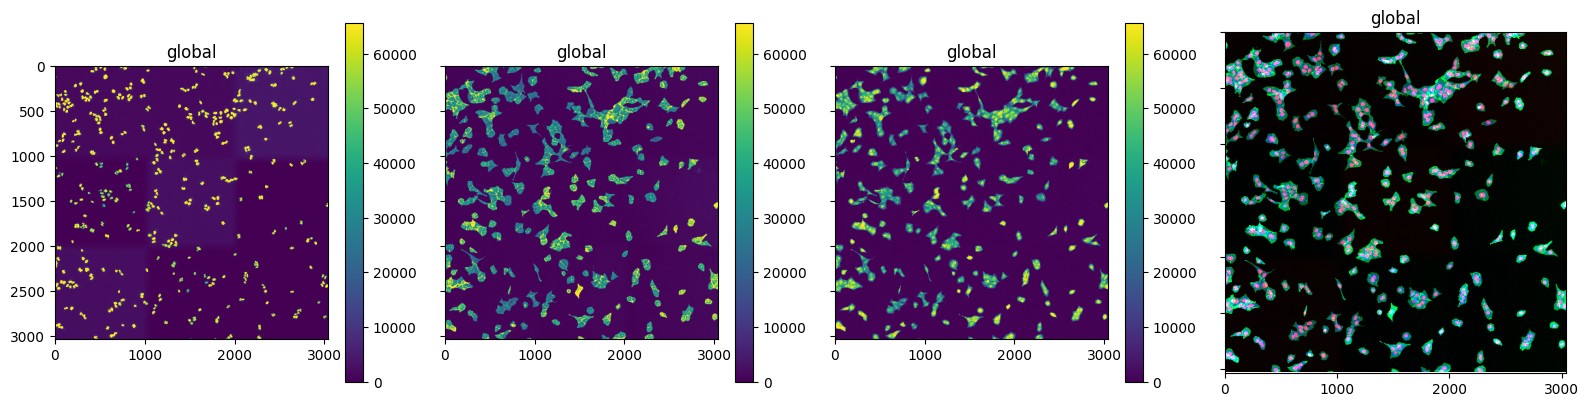

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

for idx in range(3):
    sdata.pl.render_images("czi", channel=idx).pl.show(ax=axs[idx])


sdata.pl.render_images("czi").pl.show(ax=axs[3])
plt.tight_layout()

## scPortrait Pipeline

We can now load the object into the scPortrait pipeline. We will first setup the project and then initialize the spatialdata for processing in scPortrait, using the scProtrait
method `scportrait.pipeline.project.Project.load_input_from_sdata`

In [11]:
# Setup project
project = Project(
    "./data/scportrait/project",
    config_path="./data/scportrait/config/config.yml",
    overwrite=True,
    debug=True,
    segmentation_f=WGASegmentation,
    extraction_f=HDF5CellExtraction,
    featurization_f=MLClusterClassifier,
    selection_f=LMDSelection,
)

Updating project config file.
[04/02/2025 11:17:45] Loading config from ./scportrait/project/config.yml
INFO     The Zarr backing store has been changed from None the new file path: scportrait/project/scportrait.sdata  
[04/02/2025 11:17:45] No cache directory specified in config using current working directory /Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/docs/tutorials.
[04/02/2025 11:17:45] Compression algorithm: lzf
[04/02/2025 11:17:45] No cache directory specified in config using current working directory /Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/docs/tutorials.


In [13]:
project.load_input_from_sdata(sdata_path, input_image_name="czi")

[04/02/2025 11:18:21] Output location ./scportrait/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path: scportrait/project/scportrait.sdata  
[04/02/2025 11:18:21] Image contains transformations which are removed
INFO     `dims` is specified redundantly: found also inside `data`.                                                
[04/02/2025 11:18:21] Image input_image written to sdata object.


We can now run the complete scPortrait pipeline. Please refer to the [official documentation](https://mannlabs.github.io/scPortrait/index.html) to view all functionalities. 

In [ ]:
# project.segment()